In [1]:
import torch
from torch import nn

def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

In [2]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]], dtype=torch.float32)
K = torch.tensor([[0, 1], [2, 3]], dtype=torch.float32)
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [3]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [4]:
X = torch.ones(6, 8)
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [5]:
K = torch.tensor([[1, -1]], dtype=torch.float32)

In [6]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [7]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [8]:
# Construct a convolutional layer with 1 input channel and 1 output channel
# (channels will be introduced in the following section)
# and a kernel array shape of (1, 2). For sake of simplicity we ignore bias
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))


for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= 3e-2 * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'batch {i+1}, loss {l.sum():.3f}')

batch 2, loss 6.700
batch 4, loss 1.662
batch 6, loss 0.499
batch 8, loss 0.174
batch 10, loss 0.066


In [9]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9632, -1.0148]])

In [10]:
import torch
from torch import nn
# We define a convenience function to calculate the convolutional layer. This
# function initializes the convolutional layer weights and performs
# corresponding dimensionality elevations and reductions on the input and
# output
def comp_conv2d(conv2d, X):
    # (1,1) indicates that the batch size and the number of channels
    # (described in later chapters) are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Exclude the first two dimensions that do not interest us: batch and
    # channel
    return Y.reshape(Y.shape[2:])
# Note that here 1 row or column is padded on either side, so a total of 2
# rows or columns are added
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [13]:
# Here, we use a convolution kernel with a height of 5 and a width of 3. The
# padding numbers on both sides of the height and width are 2 and 1,
# respectively
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [14]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [15]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

In [17]:
from d2l import torch as d2l
import torch

def corr2d_multi_in(X, K):
    # First, traverse along the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum([d2l.corr2d(x, k) for x, k in zip(X, K)])

In [18]:
X = torch.tensor([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
                  [[1, 2, 3], [4, 5, 6], [7, 8, 9]]], dtype=torch.float32)
K = torch.tensor([[[0, 1], [2, 3]],
                  [[1, 2], [3, 4]]], dtype=torch.float32)

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [19]:
def corr2d_multi_in_out(X, K):
    # Traverse along the 0th dimension of `K`, and each time, perform
    # cross-correlation operations with input `X`. All of the results are
    # merged together using the stack function
    return torch.stack([corr2d_multi_in(X, k) for k in K], dim=0)

In [20]:
K = torch.stack([K, K + 1, K + 2], dim=0)
K.shape

torch.Size([3, 2, 2, 2])

In [21]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [22]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.mm(K, X)  # Matrix multiplication in the fully connected layer
    return Y.reshape((c_o, h, w))

In [23]:
X = torch.randn(size=(3, 3, 3))
K = torch.randn(size=(2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

(Y1 - Y2).norm().item() < 1e-6

True

In [24]:
import torch
from torch import nn

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [25]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]], dtype=torch.float32)
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [26]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

In [27]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
print(X)

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])


In [28]:
#output is only 1x1 bc the stride is also the same as the pooling size ->  I think it's a dumb feature
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [29]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [30]:
pool2d = nn.MaxPool2d((2, 3), padding=(1, 1), stride=(2, 3))
pool2d(X)

tensor([[[[ 1.,  3.],
          [ 9., 11.],
          [13., 15.]]]])

In [31]:
X = torch.cat((X, X + 1), dim=1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [32]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

In [33]:
from d2l import torch as d2l
import torch
from torch import nn
from dataclasses import dataclass

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1,1,28,28)

net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [34]:
#notice how the first conv2d layer outputs the exact same shape -- padding
X = torch.randn(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [35]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

100.0%

Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw


111.0%

Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw


100.0%

Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw


159.1%..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw
Processing...
Done!


In [36]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    if not device:
        device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(d2l.accuracy(net(X), y), sum(y.shape))
    return metric[0] / metric[1]

In [37]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train and evaluate a model with CPU or GPU."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

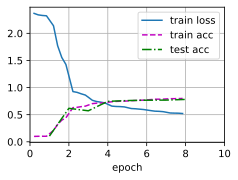

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)
#this takes some time - probably because I'm on the cpu and not gpu